In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### This notebook was created to analyze the timing between samples for three different categories of longitudinal samples (patients), those with: *mixed* infection (defined by F2 mixed measure), *re-infection* (defined by fSNP distance) and *persistent*/*clonal* infection

In [4]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

######################################################################################################################################################################################################################################################################

## Sample Annotation for all (unfiltered) Longitudinal Isolate pairs

######################################################################################################################################################################################################################################################################

In [5]:
sample_annotation_longitudinal = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/cetr_casali_walker_trauner_witney_xu_guerra_bryant_fastq_path_names_and_JankyPipe_tags.csv' , sep  = ',').set_index('patient_id')

In [6]:
np.shape(sample_annotation_longitudinal)

(614, 7)

In [7]:
sample_annotation_longitudinal.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag
patient_id,,,,,,,
I0005973-8,0,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQFF00000000,Peru3062,1,Peru3062
I0005973-8,1,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQKH00000000,Peru3315,2,Peru3315
I0005229-5,2,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQAO00000000,Peru2908,1,Peru2908
I0005229-5,3,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQKD00000000,Peru3278,2,Peru3278
I0005235-2,4,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQBA00000000,Peru2921,1,Peru2921


### F2 Mixed Measure contaminated samples

In [8]:
patients_contaminated_by_F2 = ['3162L', 'I0004290-8', '2459', 'KPS_45', 'KPS_40', 'KPS_43', 'KPS_42', '3145', 'KPS_83', 'KPS_8', '2014W', '2', '1674', '1671', 'KPS_32', 'KPS_78', '1117N', '3641', '21', '1646', 'I0001485-7', 'I0002074-8', '3443', 'KPS_65', 'KPS_63', 'KPS_69', '1669', '1667', 'KPS_20', '4098U', 'KPS_25']

In [9]:
len(patients_contaminated_by_F2)

31

In [10]:
sample_annotation_F2_contaminated = sample_annotation_longitudinal.loc[patients_contaminated_by_F2 , :]

In [11]:
np.shape(sample_annotation_F2_contaminated)

(62, 7)

In [12]:
sample_annotation_F2_contaminated.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag
patient_id,,,,,,,
3162L,560,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171166,401391.0,1,ERR171166
3162L,561,/n/data1/hms/dbmi/farhat/fastq_db/bryant/ERR17...,BRYANT,ERR171167,402713.0,2,ERR171167
I0004290-8,10,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQDN00000000,Peru3011,1,Peru3011
I0004290-8,11,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MQIU00000000,Peru3365,2,Peru3365
2459,110,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMYC00000000,Peru4946,1,Peru4946


#### Export Sample Annotation to CSV for modifying by inclusion of times between isolate collection

In [13]:
sample_annotation_F2_contaminated.drop(labels = ['fastq_files' , 'Unnamed: 0'] , axis = 1 , inplace = True)
sample_annotation_F2_contaminated['patient_id'] = list(sample_annotation_F2_contaminated.index)
sample_annotation_F2_contaminated.sort_values(by = ['population' , 'patient_id' , 'sample_order'] , inplace = True)
sample_annotation_F2_contaminated.reset_index(inplace = True , drop = True)
sample_annotation_F2_contaminated.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/contaminated_samples/F2_contaminated_longitudinal_sample_annotation.csv' , sep  = ',')

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from th

In [14]:
sample_annotation_F2_contaminated.head()

,population,run_ID,sample_ID,sample_order,tag,patient_id
0,BRYANT,ERR171155,1500034.0,1,ERR171155,1117N
1,BRYANT,ERR171154,1500283.0,2,ERR171154,1117N
2,BRYANT,ERR108127,300239.0,1,ERR108127,2014W
3,BRYANT,ERR108128,301725.0,2,ERR108128,2014W
4,BRYANT,ERR171166,401391.0,1,ERR171166,3162L


### fSNP Threshold  contaminated samples

In [15]:
patients_contaminated_by_fSNP = ['2718', 'KPS_46', 'KPS_41', '3103J', '4085U', 'KPS_80', 'I0004304-7', '3439', 'KPS_11', '3430', 'KPS_2', '1941', 'KPS_56', '1682', 'I0000221-7', '4', '1678', 'KPS_36', 'KPS_30', 'KPS_31', '4078X', 'B', 'KPS_59', 'KPS_70', 'KPS_73', 'KPS_52', 'KPS_50', 'I0001031-9', '3725', 'KPS_18', '1620', '15', 'I0004240-3', 'I0004172-8', '2492', '1657', 'KPS_67', '3100U', 'KPS_29', 'KPS_64', '3018C', '2047T', 'I0003710-6', 'P000035']

In [16]:
len(patients_contaminated_by_fSNP)

44

In [17]:
sample_annotation_fSNP_contaminated = sample_annotation_longitudinal.loc[patients_contaminated_by_fSNP , :]

In [18]:
np.shape(sample_annotation_fSNP_contaminated)

(88, 7)

In [19]:
sample_annotation_fSNP_contaminated.head()

,Unnamed: 0,fastq_files,population,run_ID,sample_ID,sample_order,tag
patient_id,,,,,,,
2718,124,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MRDO00000000,Peru5134,1,Peru5134
2718,125,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMGA00000000,Peru4741,2,Peru4741
KPS_46,450,/n/data1/hms/dbmi/farhat/fastq_db/guerra/ERR17...,GUERRA,ERR176649,NaN,1,ERR176649
KPS_46,451,/n/data1/hms/dbmi/farhat/fastq_db/guerra/ERR19...,GUERRA,ERR190334,NaN,2,ERR190334
KPS_41,440,/n/data1/hms/dbmi/farhat/fastq_db/guerra/ERR17...,GUERRA,ERR176764,NaN,1,ERR176764


#### Export Sample Annotation to CSV for modifying by inclusion of times between isolate collection

In [20]:
sample_annotation_fSNP_contaminated.drop(labels = ['fastq_files' , 'Unnamed: 0'] , axis = 1 , inplace = True)
sample_annotation_fSNP_contaminated['patient_id'] = list(sample_annotation_fSNP_contaminated.index)
sample_annotation_fSNP_contaminated.sort_values(by = ['population' , 'patient_id' , 'sample_order'] , inplace = True)
sample_annotation_fSNP_contaminated.reset_index(inplace = True , drop = True)
sample_annotation_fSNP_contaminated.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/contaminated_samples/fSNP_contaminated_longitudinal_sample_annotation.csv' , sep  = ',')

/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rv76/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from th

In [21]:
sample_annotation_fSNP_contaminated.head()

,population,run_ID,sample_ID,sample_order,tag,patient_id
0,BRYANT,ERR966621,401063.0,1,ERR966621,2047T
1,BRYANT,ERR108140,402106.0,2,ERR108140,2047T
2,BRYANT,ERR108143,300191.0,1,ERR108143,3018C
3,BRYANT,ERR108144,302235.0,2,ERR108144,3018C
4,BRYANT,ERR108152,300659.0,1,ERR108152,3100U


######################################################################################################################################################################################################################################################################

## Import Annotation Files with Dates and get *time between isolate collection* for different groups of subjects

######################################################################################################################################################################################################################################################################

### A: F2 Mixed Measure (*mixed*)

In [22]:
time_between_serial_isolate_collection = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/contaminated_samples/F2_contaminated_longitudinal_sample_annotation_with_collection_times.csv').set_index('population')

In [23]:
time_between_serial_isolate_collection.head()

,run_ID,sample_ID,sample_order,tag,patient_id,date_information,tube_label (cetr)
population,,,,,,,
BRYANT,ERR171155,1500034,1,ERR171155,1117N,0,NaN
BRYANT,ERR171154,1500283,2,ERR171154,1117N,17,NaN
BRYANT,ERR108127,300239,1,ERR108127,2014W,0,NaN
BRYANT,ERR108128,301725,2,ERR108128,2014W,36,NaN
BRYANT,ERR171166,401391,1,ERR171166,3162L,0,NaN


In [24]:
np.shape(time_between_serial_isolate_collection)

(62, 7)

#### Retain only patients that for which we have date Information for both samples

In [25]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )

#get a boolean to check that there are dates for both samples
dates_for_both_samples = [ ( (isinstance(date_1, basestring)) and (isinstance(date_2, basestring)) ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [26]:
np.shape(time_between_serial_isolate_collection)

(62, 7)

In [27]:
np.shape(time_between_serial_isolate_collection_dropped)

(0, 7)

#### Retain only patients that have different dates of collection for both samples

In [28]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )

#get a boolean to check that there are dates for both samples
dates_different_for_both_samples = [ ( date_1 != date_2 ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_different_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [29]:
np.shape(time_between_serial_isolate_collection)

(62, 7)

In [30]:
np.shape(time_between_serial_isolate_collection_dropped )

(0, 7)

In [31]:
time_between_serial_isolate_collection_dropped 

,run_ID,sample_ID,sample_order,tag,patient_id,date_information,tube_label (cetr)
population,,,,,,,


#### Find distance between all pairs of times

In [32]:
pairwise_isolate_time = pd.DataFrame(index = patients_to_keep , columns = ['population' , 'time_between_collection'])

for patient_id in patients_to_keep:
    
    population = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id].index[0]
    
    #append info to dataframe
    pairwise_isolate_time.loc[patient_id , 'population'] = population

In [33]:
pairwise_isolate_time.head()

,population,time_between_collection
1117N,BRYANT,NaN
2014W,BRYANT,NaN
3162L,BRYANT,NaN
4098U,BRYANT,NaN
1646,CETR,NaN


In [34]:
for patient_id in pairwise_isolate_time.index:
    
    population = pairwise_isolate_time.loc[patient_id , 'population']
    patient_id = patient_id
    
    if population == 'BRYANT':
        
        bryant_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]
        
        first_date = bryant_pair[bryant_pair.sample_order == 1].date_information.values[0]
        second_date = bryant_pair[bryant_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
    
    if population == 'CASALI':
        
        casali_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = casali_pair[casali_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[0]
        month = first_date.split('/')[1]
        year = '20' + first_date.split('/')[2]
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = casali_pair[casali_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[0]
        month = second_date.split('/')[1]
        year = '20' + second_date.split('/')[2]
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'CETR') or (population == 'GUERRA') or (population == 'WITNEY') or (population == 'XU'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[1]
        month = first_date.split('/')[0]
        if int(first_date.split('/')[2]) in range(50,100): #some dates in 1990's others in 2000's
            year = '19' + first_date.split('/')[2]
        else:
            year = '20' + first_date.split('/')[2]

        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))


        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[1]
        month = second_date.split('/')[0]
        if int(second_date.split('/')[2]) in range(50,100):
            year = '19' + second_date.split('/')[2]
        else:
            year = '20' + second_date.split('/')[2]

        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'TRAUNER') or (population == 'BRYANT'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
        
    elif population == 'WALKER':
        
        walker_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = walker_pair[walker_pair.sample_order == 1].date_information.values[0]
        day = '1'
        month = '1'
        year = first_date
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = walker_pair[walker_pair.sample_order == 2].date_information.values[0]
        day = '1'
        month = '1'
        year = second_date
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    #append distance between isolate collection
    pairwise_isolate_time.loc[patient_id , 'time_between_collection'] = num_days_between

In [35]:
pairwise_isolate_time.head()

,population,time_between_collection
1117N,BRYANT,119
2014W,BRYANT,252
3162L,BRYANT,252
4098U,BRYANT,336
1646,CETR,374


In [36]:
np.mean( pairwise_isolate_time.time_between_collection )

647.1935483870968

In [37]:
F2_contaminated_pairwise_isolate_times = pairwise_isolate_time.time_between_collection

### B: fSNP Measure  (*re-infection*)

In [38]:
time_between_serial_isolate_collection = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/contaminated_samples/fSNP_contaminated_longitudinal_sample_annotation_with_collection_times.csv').set_index('population')

In [39]:
time_between_serial_isolate_collection.head()

,run_ID,sample_ID,sample_order,tag,patient_id,date_information,tube_label (cetr)
population,,,,,,,
BRYANT,ERR966621,401063,1,ERR966621,2047T,0,NaN
BRYANT,ERR108140,402106,2,ERR108140,2047T,26,NaN
BRYANT,ERR108143,300191,1,ERR108143,3018C,0,NaN
BRYANT,ERR108144,302235,2,ERR108144,3018C,48,NaN
BRYANT,ERR108152,300659,1,ERR108152,3100U,0,NaN


In [40]:
np.shape(time_between_serial_isolate_collection)

(88, 7)

#### Retain only patients that for which we have date Information for both samples

In [41]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )

#get a boolean to check that there are dates for both samples
dates_for_both_samples = [ ( (isinstance(date_1, basestring)) and (isinstance(date_2, basestring)) ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [42]:
np.shape(time_between_serial_isolate_collection)

(86, 7)

In [43]:
np.shape(time_between_serial_isolate_collection_dropped )

(2, 7)

In [44]:
time_between_serial_isolate_collection_dropped 

,run_ID,sample_ID,sample_order,tag,patient_id,date_information,tube_label (cetr)
population,,,,,,,
BRYANT,ERR171136,200470,1,ERR171136,4085U,0,NaN
BRYANT,ERR171137,201113,2,ERR171137,4085U,NaN,NaN


Dropped 1 patient from Bryant et. al. dataset that didn't have date information both both isolates 

#### Retain only patients that have different dates of collection for both samples

In [45]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 5] )

#get a boolean to check that there are dates for both samples
dates_different_for_both_samples = [ ( date_1 != date_2 ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_different_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [46]:
np.shape(time_between_serial_isolate_collection)

(86, 7)

In [47]:
np.shape(time_between_serial_isolate_collection_dropped )

(0, 7)

In [48]:
time_between_serial_isolate_collection_dropped 

,run_ID,sample_ID,sample_order,tag,patient_id,date_information,tube_label (cetr)
population,,,,,,,


#### Find distance between all pairs of times

In [49]:
pairwise_isolate_time = pd.DataFrame(index = patients_to_keep , columns = ['population' , 'time_between_collection'])

for patient_id in patients_to_keep:
    
    population = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id].index[0]
    
    #append info to dataframe
    pairwise_isolate_time.loc[patient_id , 'population'] = population

In [50]:
pairwise_isolate_time.head()

,population,time_between_collection
2047T,BRYANT,NaN
3018C,BRYANT,NaN
3100U,BRYANT,NaN
3103J,BRYANT,NaN
4078X,BRYANT,NaN


In [51]:
for patient_id in pairwise_isolate_time.index:
    
    population = pairwise_isolate_time.loc[patient_id , 'population']
    patient_id = patient_id
    
    if population == 'BRYANT':
        
        bryant_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]
        
        first_date = bryant_pair[bryant_pair.sample_order == 1].date_information.values[0]
        second_date = bryant_pair[bryant_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
    
    if population == 'CASALI':
        
        casali_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = casali_pair[casali_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[0]
        month = first_date.split('/')[1]
        year = '20' + first_date.split('/')[2]
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = casali_pair[casali_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[0]
        month = second_date.split('/')[1]
        year = '20' + second_date.split('/')[2]
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'CETR') or (population == 'GUERRA') or (population == 'WITNEY') or (population == 'XU'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[1]
        month = first_date.split('/')[0]
        if int(first_date.split('/')[2]) in range(50,100): #some dates in 1990's others in 2000's
            year = '19' + first_date.split('/')[2]
        else:
            year = '20' + first_date.split('/')[2]

        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))


        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[1]
        month = second_date.split('/')[0]
        if int(second_date.split('/')[2]) in range(50,100):
            year = '19' + second_date.split('/')[2]
        else:
            year = '20' + second_date.split('/')[2]

        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'TRAUNER') or (population == 'BRYANT'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
        
    elif population == 'WALKER':
        
        walker_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = walker_pair[walker_pair.sample_order == 1].date_information.values[0]
        day = '1'
        month = '1'
        year = first_date
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = walker_pair[walker_pair.sample_order == 2].date_information.values[0]
        day = '1'
        month = '1'
        year = second_date
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    #append distance between isolate collection
    pairwise_isolate_time.loc[patient_id , 'time_between_collection'] = num_days_between

In [52]:
pairwise_isolate_time.head()

,population,time_between_collection
2047T,BRYANT,182
3018C,BRYANT,336
3100U,BRYANT,420
3103J,BRYANT,182
4078X,BRYANT,420


In [53]:
fSNP_contaminated_pairwise_isolate_times = pairwise_isolate_time.time_between_collection

### C: filtered longitudinal isolate pairs  (*persistent*)

In [54]:
time_between_serial_isolate_collection = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_sample_annotation_for_temporal_analysis_with_dates.csv').set_index('population')

In [55]:
time_between_serial_isolate_collection.head()

,Unnamed: 0,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,,
BRYANT,0,ERR108130,400044,1,ERR108130,longitudinal,2020E,0,NaN,NaN
BRYANT,1,ERR108129,401206,2,ERR108129,longitudinal,2020E,36,NaN,NaN
BRYANT,2,ERR108131,400673,1,ERR108131,longitudinal,2027W,0,NaN,NaN
BRYANT,3,ERR108132,402568,2,ERR108132,longitudinal,2027W,48,NaN,NaN
BRYANT,4,ERR108133,400711,1,ERR108133,longitudinal,2028K,0,NaN,NaN


In [56]:
np.shape(time_between_serial_isolate_collection)

(400, 10)

#### Retain only patients that for which we have date Information for both samples

In [57]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )

#get a boolean to check that there are dates for both samples
dates_for_both_samples = [ ( (isinstance(date_1, basestring)) and (isinstance(date_2, basestring)) ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [58]:
np.shape(time_between_serial_isolate_collection)

(396, 10)

In [59]:
np.shape(time_between_serial_isolate_collection_dropped )

(4, 10)

In [60]:
time_between_serial_isolate_collection_dropped 

,Unnamed: 0,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,,
WITNEY,380,ERR1750925,SAMEA23779168,1,ERR1750925,longitudinal,27,NaN,NaN,NaN
WITNEY,381,ERR1750926,SAMEA23779918,2,ERR1750926,longitudinal,27,1/25/11,NaN,NaN
WITNEY,382,ERR1750927,SAMEA23780668,1,ERR1750927,longitudinal,28,NaN,NaN,NaN
WITNEY,383,ERR1750928,SAMEA23781418,2,ERR1750928,longitudinal,28,8/3/11,NaN,NaN


#### Retain only patients that have different dates of collection for both samples

In [61]:
#get dates for each sample in pair
dates_for_first_sample = list( time_between_serial_isolate_collection.iloc[range(0 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )
dates_for_second_sample = list( time_between_serial_isolate_collection.iloc[range(1 , np.shape(time_between_serial_isolate_collection)[0] , 2) , 7] )

#get a boolean to check that there are dates for both samples
dates_different_for_both_samples = [ ( date_1 != date_2 ) for date_1 , date_2 in zip(dates_for_first_sample , dates_for_second_sample) ]

#get list of patients to include that have dates for sample retreival for both samples
patients_to_keep = list( time_between_serial_isolate_collection[time_between_serial_isolate_collection.sample_order == 1][dates_different_for_both_samples].patient_id )

#filter out patients with 1 or 2 missing dates
time_between_serial_isolate_collection_filter = [patient in patients_to_keep for patient in list(time_between_serial_isolate_collection.patient_id)]
time_between_serial_isolate_dropped_filter = [not dates_both_isolates for dates_both_isolates in time_between_serial_isolate_collection_filter]

time_between_serial_isolate_collection_dropped = time_between_serial_isolate_collection[time_between_serial_isolate_dropped_filter]
time_between_serial_isolate_collection = time_between_serial_isolate_collection[time_between_serial_isolate_collection_filter]

In [62]:
np.shape(time_between_serial_isolate_collection)

(390, 10)

In [63]:
np.shape(time_between_serial_isolate_collection_dropped )

(6, 10)

In [64]:
time_between_serial_isolate_collection_dropped 

,Unnamed: 0,run_ID,sample_ID,sample_order,tag,isolate_type,patient_id,date_information,tube_label (cetr),tag.1
population,,,,,,,,,,
WALKER,310,ERR046918,NaN,1,ERR046918,longitudinal,P000059,2007,NaN,NaN
WALKER,311,ERR046933,NaN,2,ERR046933,longitudinal,P000059,2007,NaN,NaN
WALKER,342,ERR047010,NaN,1,ERR047010,longitudinal,P000259,2008,NaN,NaN
WALKER,343,ERR047012,NaN,2,ERR047012,longitudinal,P000259,2008,NaN,NaN
WALKER,346,ERR047007,NaN,1,ERR047007,longitudinal,P000267,2007,NaN,NaN
WALKER,347,ERR072030,NaN,2,ERR072030,longitudinal,P000267,2007,NaN,NaN


#### Find distance between all pairs of times

In [65]:
pairwise_isolate_time = pd.DataFrame(index = patients_to_keep , columns = ['population' , 'time_between_collection'])

for patient_id in patients_to_keep:
    
    population = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id].index[0]
    
    #append info to dataframe
    pairwise_isolate_time.loc[patient_id , 'population'] = population

In [66]:
pairwise_isolate_time.head()

,population,time_between_collection
2020E,BRYANT,NaN
2027W,BRYANT,NaN
2028K,BRYANT,NaN
2041Q,BRYANT,NaN
2043R,BRYANT,NaN


In [67]:
for patient_id in pairwise_isolate_time.index:
    
    population = pairwise_isolate_time.loc[patient_id , 'population']
    patient_id = patient_id
    
    if population == 'BRYANT':
        
        bryant_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]
        
        first_date = bryant_pair[bryant_pair.sample_order == 1].date_information.values[0]
        second_date = bryant_pair[bryant_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
    
    if population == 'CASALI':
        
        casali_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = casali_pair[casali_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[0]
        month = first_date.split('/')[1]
        year = '20' + first_date.split('/')[2]
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = casali_pair[casali_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[0]
        month = second_date.split('/')[1]
        year = '20' + second_date.split('/')[2]
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'CETR') or (population == 'GUERRA') or (population == 'WITNEY') or (population == 'XU'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        day = first_date.split('/')[1]
        month = first_date.split('/')[0]
        if int(first_date.split('/')[2]) in range(50,100): #some dates in 1990's others in 2000's
            year = '19' + first_date.split('/')[2]
        else:
            year = '20' + first_date.split('/')[2]

        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))


        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]
        day = second_date.split('/')[1]
        month = second_date.split('/')[0]
        if int(second_date.split('/')[2]) in range(50,100):
            year = '19' + second_date.split('/')[2]
        else:
            year = '20' + second_date.split('/')[2]

        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    elif (population == 'TRAUNER') or (population == 'BRYANT'):
        
        serial_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = serial_pair[serial_pair.sample_order == 1].date_information.values[0]
        second_date = serial_pair[serial_pair.sample_order == 2].date_information.values[0]

        num_days_between = (int(second_date) - int(first_date))*7 #dates are in # of weeks apart
        
    elif population == 'WALKER':
        
        walker_pair = time_between_serial_isolate_collection[time_between_serial_isolate_collection.patient_id == patient_id]

        first_date = walker_pair[walker_pair.sample_order == 1].date_information.values[0]
        day = '1'
        month = '1'
        year = first_date
        first_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        second_date = walker_pair[walker_pair.sample_order == 2].date_information.values[0]
        day = '1'
        month = '1'
        year = second_date
        second_date = pd.to_datetime(pd.DataFrame({'year':[year] , 'month':[month] , 'day':[day]}))

        num_days_between = (second_date - first_date).dt.days[0]
        
    #append distance between isolate collection
    pairwise_isolate_time.loc[patient_id , 'time_between_collection'] = num_days_between

In [68]:
pairwise_isolate_time.head()

,population,time_between_collection
2020E,BRYANT,252
2027W,BRYANT,336
2028K,BRYANT,182
2041Q,BRYANT,182
2043R,BRYANT,252


In [69]:
filtered_persistent_pairwise_isolate_times = pairwise_isolate_time.time_between_collection

######################################################################################################################################################################################################################################################################

## Compare F2 (mixed) samples and fSNP (re-infection) samples with filtered (persistent) samples

######################################################################################################################################################################################################################################################################

### Using 1.7 months as the *duration* threshold for treatment treshold

In [76]:
F2_contaminated_pairwise_isolate_times_months = F2_contaminated_pairwise_isolate_times/30.0
fSNP_contaminated_pairwise_isolate_times_months = fSNP_contaminated_pairwise_isolate_times/30.0
filtered_persistent_pairwise_isolate_times_months = filtered_persistent_pairwise_isolate_times/30.0

In [80]:
np.shape(F2_contaminated_pairwise_isolate_times_months[F2_contaminated_pairwise_isolate_times_months >= 1.7])

(30,)

In [81]:
np.shape(fSNP_contaminated_pairwise_isolate_times_months[fSNP_contaminated_pairwise_isolate_times_months >= 1.7])

(39,)

In [82]:
np.shape(filtered_persistent_pairwise_isolate_times_months[filtered_persistent_pairwise_isolate_times_months >= 1.7])

(178,)

### Mixed (F2 filter) isolate pairs

In [70]:
np.mean( F2_contaminated_pairwise_isolate_times )

647.1935483870968

In [71]:
np.median( F2_contaminated_pairwise_isolate_times )

336.0

In [72]:
len(F2_contaminated_pairwise_isolate_times[ F2_contaminated_pairwise_isolate_times < 60 ])

3

In [73]:
len(F2_contaminated_pairwise_isolate_times[ F2_contaminated_pairwise_isolate_times >= 60 ])

28

### Re-infection (fSNP filter) isolate pairs

In [74]:
np.mean( fSNP_contaminated_pairwise_isolate_times )

1019.1395348837209

In [75]:
np.median( fSNP_contaminated_pairwise_isolate_times )

538

In [76]:
len(fSNP_contaminated_pairwise_isolate_times[ fSNP_contaminated_pairwise_isolate_times < 60 ])

8

In [77]:
len(fSNP_contaminated_pairwise_isolate_times[ fSNP_contaminated_pairwise_isolate_times >= 60 ])

35

### Persistent (passed all filters) isolate pairs

In [78]:
np.mean( filtered_persistent_pairwise_isolate_times )

427.20512820512823

In [79]:
np.median( filtered_persistent_pairwise_isolate_times )

281

In [80]:
len(filtered_persistent_pairwise_isolate_times[ filtered_persistent_pairwise_isolate_times < 60 ])

28

In [81]:
len(filtered_persistent_pairwise_isolate_times[ filtered_persistent_pairwise_isolate_times >= 60 ])

167

### Total Number of Isolate Pairs & Number of Isolate Pairs with collections times $\ge$ 2 months/60 days

In [82]:
3 + 28 + 8 + 35 + 28 + 167 #total number of pairs

269

In [83]:
28 + 35 + 167 #total number of isolate pairs with collection times >= 2 months

230

### Plot *time between isolate collection* for *mixed* group and *re-infection* group

In [64]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

In [65]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 3.0

# function for setting the colors of the box plots pairs
def setBoxColors(bp , color):
    setp(bp['boxes'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['fliers'][0], color=color , alpha = 0.65)
    setp(bp['medians'][0], color=color , linewidth = 3.0)
    bp['fliers'][0].set_markerfacecolor(color)
    bp['fliers'][0].set_markeredgewidth(0.5)
    bp['fliers'][0].set_markersize(6.0)
    bp['fliers'][0].set_markeredgecolor('white')
    
def values_to_variant_types(values):
    SNP_vals = values.alt_AF_diff
    return [SNP_vals]

def color_bar(bar , color):
    bar.set_color(color)
    bar.set_edgecolor('k')
    bar.set_linewidth(1.0)

/home/rv76/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


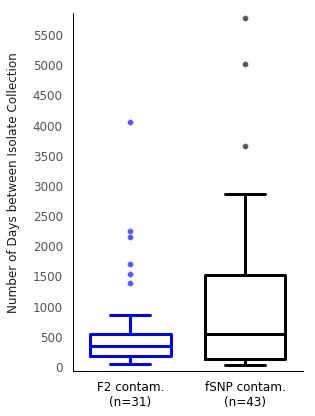

In [66]:
fig = plt.figure(1, figsize=(4.25, 6.0))
ax1 = axes()

box_width = 0.7
ind = [1,2]

### Example in case we want to show means later ###
##Syn_values = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'S']
##meanlineprops = dict(linestyle='--' , color = 'b' , linewidth = linewidth_for_box)
##bp = ax1.boxplot(values_to_variant_types(Syn_values) , positions = [ind[0]], widths = box_width , meanprops = meanlineprops, meanline = True, showmeans = True)
##setBoxColors(bp , 'b')

#times between isolate collection for F2 contaminated samples
bp = ax1.boxplot(F2_contaminated_pairwise_isolate_times.values.astype(float) , positions = [ind[0]], widths = box_width)
setBoxColors(bp , 'blue')

#times between isolate collection for fSNP contaminated samples
bp = ax1.boxplot(fSNP_contaminated_pairwise_isolate_times.values.astype(float) , positions = [ind[1]], widths = box_width)
setBoxColors(bp , 'black')

max_time_btwn_collection = max(np.max(F2_contaminated_pairwise_isolate_times.values) , np.max(fSNP_contaminated_pairwise_isolate_times.values) )

#y-labels
ax1.set_ylim([-75 , max_time_btwn_collection + 75])
ax1.set_yticks(range(0 , max_time_btwn_collection , 500))
y_labels = range(0 , max_time_btwn_collection , 500)
ax1.set_yticklabels(y_labels, rotation='horizontal', fontsize = 12)  
ax1.tick_params(axis='y', which='major', labelsize=12, pad = 4)

#x-labels
ax1.set_xlim([0.5 , 2.5])
ax1.set_xticks(ind)
x_labels = ['F2 contam.\n(n=' + str(len(F2_contaminated_pairwise_isolate_times)) + ')', 'fSNP contam.\n(n=' + str(len(fSNP_contaminated_pairwise_isolate_times)) + ')']
ax1.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)  

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#label y-axis
fig.text(-0.013, 0.56, 'Number of Days between Isolate Collection',  ha='center', va='center', rotation=90, fontsize = 12 , color = 'k')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

fig = plt.gcf()
fig.tight_layout()

#output for Adobe Illustrator
#file_name = '/home/rv76/Farhat_Lab/Figures/Final_5/Sample_Summary/times_between_serial_isolate_collection_AR_SNPs_vs_no_AR_SNPs.pdf'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [67]:
#compute Mann-Whitnes U test
non_parametric_test_pval = scipy.stats.mannwhitneyu(F2_contaminated_pairwise_isolate_times.values , fSNP_contaminated_pairwise_isolate_times.values )[1]

In [68]:
non_parametric_test_pval

0.21993464470036528